In [1]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms

In [2]:
from sklearn.model_selection import train_test_split
from PIL import Image
import os

dataset_path = './dataset/UTKFace/'
file_list = os.listdir(dataset_path)

ages = [int(file.split('_')[0]) for file in file_list]
genders = [int(file.split('_')[1]) for file in file_list]  # 0 for Male, 1 for Female
df = pd.DataFrame({'filename': file_list, 'age': ages, 'gender': genders})

proj_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df, val_df = train_test_split(proj_df, test_size=0.3, random_state=42)

#proj_df, test_df = train_test_split(df, test_size=0.3, stratify=df['gender'], random_state=42)

#train_df, val_df = train_test_split(proj_df, test_size=0.3, stratify=proj_df['gender'], random_state=42)

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ridimensiona le immagini a 64x64
    transforms.ToTensor(),         # Converte le immagini in tensori
])

mean = [0.59609047, 0.4563706, 0.3906234];
std = [0.21890544, 0.19489454, 0.18570753];

# Create a separate data augmentation transform
augmentation_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ridimensiona le immagini a 64x64
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),         # Converte le immagini in tensori
#    transforms.Normalize(mean=mean, std=std)
])

class UTKFaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        age = self.dataframe.iloc[idx, 1]
        gender = self.dataframe.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, gender, age

# Crea istanze del dataset per addestramento e test
base_train_dataset = UTKFaceDataset(dataframe=train_df, root_dir=dataset_path, transform=transform)
aug_train_dataset = UTKFaceDataset(dataframe=train_df, root_dir=dataset_path, transform=augmentation_transform)
train_dataset = ConcatDataset([base_train_dataset, aug_train_dataset])

val_dataset = UTKFaceDataset(dataframe=val_df, root_dir=dataset_path, transform=transform)
test_dataset = UTKFaceDataset(dataframe=test_df, root_dir=dataset_path, transform=transform)

# Crea DataLoader per iterare sui dati durante l'addestramento
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

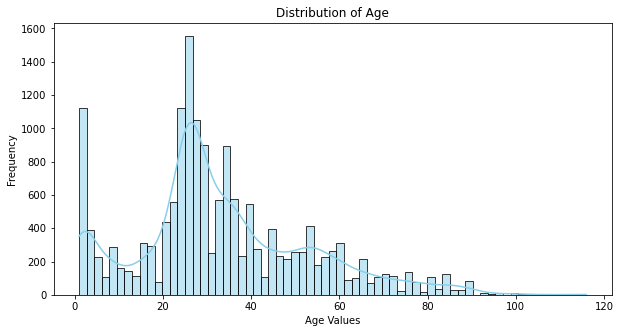

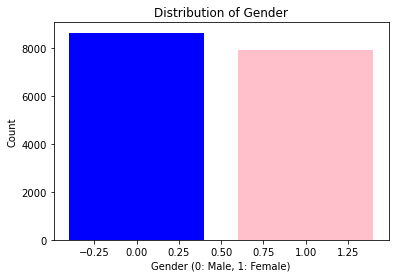

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Plot the distribution of the continuous feature
plt.figure(figsize=(10, 5))
sns.histplot(proj_df['age'], kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age Values')
plt.ylabel('Frequency')
plt.show()

# Count occurrences of each gender value
unique_values, counts = np.unique(proj_df['gender'], return_counts=True)

# Plot the distribution
plt.bar(unique_values, counts, color=['blue', 'pink'])  # You can choose different colors
plt.title('Distribution of Gender')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')

plt.show()

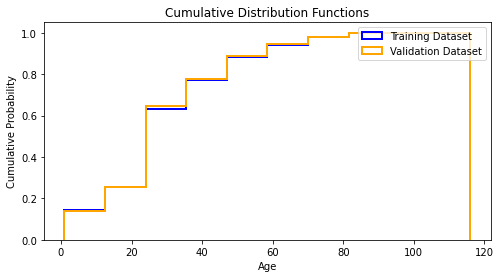

KS Statistic: 0.015340670485460395
P-value: 0.38119496384617246
The distributions are similar (fail to reject the null hypothesis)


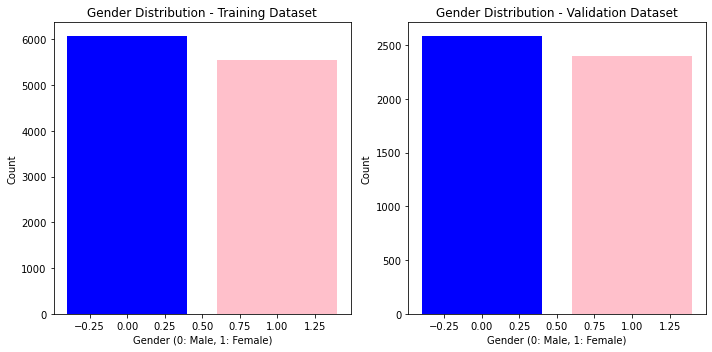

In [4]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Generate example data for two datasets (replace this with your actual data)
age_data1 = train_df['age']
age_data2 = val_df['age']
gender_data1 = train_df['gender']
gender_data2 = val_df['gender']

# Perform KS test
statistic, p_value = ks_2samp(age_data1, age_data2)

# Plot the cumulative distribution functions (CDFs) for visual inspection
plt.figure(figsize=(8, 4))
plt.hist(age_data1, cumulative=True, density=True, histtype='step', label='Training Dataset', color='blue', linewidth=2)
plt.hist(age_data2, cumulative=True, density=True, histtype='step', label='Validation Dataset', color='orange', linewidth=2)
plt.title('Cumulative Distribution Functions')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

# Print the KS test result
print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05  # significance level
if p_value > alpha:
    print("The distributions are similar (fail to reject the null hypothesis)")
else:
    print("The distributions are different (reject the null hypothesis)")
    
# Plot the distribution of gender
plt.figure(figsize=(10, 5))

unique_values, counts = np.unique(gender_data1, return_counts=True)
# Plot for Dataset 1
plt.subplot(1, 2, 1)
plt.bar(unique_values, counts, color=['blue', 'pink'])
plt.title('Gender Distribution - Training Dataset')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')

unique_values, counts = np.unique(gender_data2, return_counts=True)
# Plot for Dataset 2
plt.subplot(1, 2, 2)
plt.bar(unique_values, counts, color=['blue', 'pink'])
plt.title('Gender Distribution - Validation Dataset')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [5]:
# Initialize variables to accumulate sum and sum of squares
#mean_sum = np.zeros(3)
#std_sum = np.zeros(3)
#count = 0

# Loop through each image to accumulate sum and sum of squares
#for idx, row in df.iterrows():
#    img_path = os.path.join(dataset_path, row['filename'])
#    img = Image.open(img_path).convert('RGB')
#    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    
#    mean_sum += np.mean(img_array, axis=(0, 1))
#    std_sum += np.std(img_array, axis=(0, 1))
    
#    count += 1

# Calculate mean and std
#mean = mean_sum / count
#std = std_sum / count

#print("Mean:", mean)
#print("Std:", std)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GenderClassifier(nn.Module):
    def __init__(self):
        super(GenderClassifier, self).__init__()

        # CNN architecture
        self.shared_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dimensione dell'output dopo le CNN

        # Branca per il genere
        self.gender_fc = nn.Sequential(
            nn.Linear(16384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        # Implementa la logica di propagazione in avanti
        cnn_output = self.shared_cnn(x)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)

        # Branca per il genere
        gender_output = self.gender_fc(cnn_output)

        return gender_output
    
    def get_conv_layers(self):
        return [idx for idx, layer in enumerate(model.children()) if isinstance(layer, nn.Conv2d)]
    
class AgeClassifier(nn.Module):
    def __init__(self):
        super(AgeClassifier, self).__init__()

        # CNN architecture
        self.shared_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dimensione dell'output dopo le CNN

        # Branca per l'età
        self.age_fc = nn.Sequential(
            nn.Linear(16384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # Implementa la logica di propagazione in avanti
        cnn_output = self.shared_cnn(x)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)

        # Branca per l'età
        age_output = self.age_fc(cnn_output)

        return age_output
    
    def get_conv_layers(self):
        return [idx for idx, layer in enumerate(model.children()) if isinstance(layer, nn.Conv2d)]


# Inizializza il modello
gender_model = GenderClassifier()
age_model = AgeClassifier()

In [7]:
criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

optimizer_gender = optim.Adam(gender_model.parameters(), lr=0.01)
optimizer_age = optim.Adam(age_model.parameters(), lr=0.01)

In [8]:
#model.load_state_dict(torch.load('gender_age_model.pth', map_location=torch.device('cpu')))

In [9]:
from sklearn.metrics import r2_score
import time

# Numero massimo di epoche di addestramento
num_epochs = 50

# Liste per salvare l'andamento della perdita
train_loss_list = []
val_loss_list = []

# Liste per salvare l'andamento dell'accuratezza
train_gender_accuracy_list = []
val_gender_accuracy_list = []

if torch.cuda.is_available():
    gender_model = gender_model.cuda()
    
# Specify the patience parameter, which is the number of epochs with no improvement after which training will be stopped
patience = 3
best_val_loss = float('inf')
no_improvement_count = 0

begin = time.time()
# Addestramento del modello
for epoch in range(num_epochs):
    
    correct_gender_train = 0
    total_train = 0
    
    gender_model.train()
    
    for inputs, gender_labels, _ in train_loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
        optimizer_gender.zero_grad()
        gender_output = gender_model(inputs)
        
        # Sposta l'output alla stessa device di gender_labels
        gender_output = gender_output.to(gender_labels.device)

        # Calcola le perdite per entrambe le attività
        gender_loss = criterion_gender(gender_output, gender_labels)
        
        # Calcola la perdita totale
        total_loss = gender_loss
        
        # Esegui la retropropagazione e l'aggiornamento dei pesi
        total_loss.backward()
        optimizer_gender.step()
        
        # Calcola l'accuratezza per il genere
        _, predicted_gender = torch.max(gender_output, 1)
        correct_gender_train += (predicted_gender == gender_labels).sum().item()
        total_train += gender_labels.size(0)

    train_loss_list.append(total_loss.item())

    train_gender_accuracy = correct_gender_train / total_train
        
    # Valuta il modello sul set di val
    gender_model.eval()
    with torch.no_grad():
        
        correct_gender_val = 0
        total_val = 0
        
        val_loss_gender = 0.0
        total_samples = 0

        for inputs, gender_labels, _ in val_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                gender_labels = gender_labels.cuda()
            gender_output = gender_model(inputs)

            # Sposta l'output alla stessa device di gender_labels
            gender_output = gender_output.to(gender_labels.device)
            
            val_loss_gender += criterion_gender(gender_output, gender_labels).item()
            total_samples += len(inputs)
            
            # Calcola l'accuratezza per il genere
            _, predicted_gender = torch.max(gender_output, 1)
            correct_gender_val += (predicted_gender == gender_labels).sum().item()
            total_val += gender_labels.size(0)

    val_gender_accuracy = correct_gender_val / total_val

    train_gender_accuracy_list.append(train_gender_accuracy)
    val_gender_accuracy_list.append(val_gender_accuracy)

    avg_val_loss_gender = val_loss_gender / total_samples
    total_val_loss = avg_val_loss_gender

    val_loss_list.append(total_val_loss)

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {total_loss.item():.4f}, '
          f'val Loss: {total_val_loss:.4f}, '
          f'No Improvement Count: {no_improvement_count}')

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Gender Accuracy: {train_gender_accuracy:.4f}, val Gender Accuracy: {val_gender_accuracy:.4f}')

    if no_improvement_count >= patience:
        print(f'Early stopping after {patience} epochs with no improvement.')
        break

end = time.time()
total_time = end - begin
print(f'Total Training Time: {total_time}')
        
# Salva il modello addestrato se necessario
torch.save(gender_model.state_dict(), 'gender_model.pth')

print(f'Total Training Samples: {total_train},  Total Validation Samples: {total_val}')

Epoch [1/50], Train Loss: 0.3104, val Loss: 0.0050, No Improvement Count: 0
Epoch [1/50], Train Gender Accuracy: 0.7881, val Gender Accuracy: 0.8518
Epoch [2/50], Train Loss: 0.2834, val Loss: 0.0052, No Improvement Count: 1
Epoch [2/50], Train Gender Accuracy: 0.8725, val Gender Accuracy: 0.8423
Epoch [3/50], Train Loss: 0.1996, val Loss: 0.0039, No Improvement Count: 0
Epoch [3/50], Train Gender Accuracy: 0.8936, val Gender Accuracy: 0.8907
Epoch [4/50], Train Loss: 0.1572, val Loss: 0.0039, No Improvement Count: 0
Epoch [4/50], Train Gender Accuracy: 0.9135, val Gender Accuracy: 0.8942
Epoch [5/50], Train Loss: 0.2268, val Loss: 0.0039, No Improvement Count: 1
Epoch [5/50], Train Gender Accuracy: 0.9227, val Gender Accuracy: 0.8988
Epoch [6/50], Train Loss: 0.1678, val Loss: 0.0038, No Improvement Count: 0
Epoch [6/50], Train Gender Accuracy: 0.9338, val Gender Accuracy: 0.9032
Epoch [7/50], Train Loss: 0.2441, val Loss: 0.0041, No Improvement Count: 1
Epoch [7/50], Train Gender Acc

In [10]:
from sklearn.metrics import r2_score
import time

# Numero massimo di epoche di addestramento
num_epochs = 50

# Liste per salvare l'andamento della perdita
train_loss_list = []
val_loss_list = []

# Liste per salvare l'andamento dell'accuratezza
train_age_r2_list = []
val_age_r2_list = []

if torch.cuda.is_available():
    age_model = age_model.cuda()
    
# Specify the patience parameter, which is the number of epochs with no improvement after which training will be stopped
patience = 3
best_val_loss = float('inf')
no_improvement_count = 0

begin = time.time()
# Addestramento del modello
for epoch in range(num_epochs):
    
    train_age_r2 = 0
    
    age_model.train()
    
    for inputs, _, age_labels in train_loader:
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            age_labels = age_labels.cuda()
        optimizer_age.zero_grad()
        age_output = age_model(inputs)
        
        # Sposta l'output alla stessa device di gender_labels
        age_output = age_output.to(age_labels.device)

        # Calcola le perdite per entrambe le attività
        age_loss = criterion_age(age_output, age_labels)
        
        # Calcola la perdita totale
        total_loss = age_loss
        
        # Esegui la retropropagazione e l'aggiornamento dei pesi
        total_loss.backward()
        optimizer_age.step()

        # Calcola l'R2 score per l'età
        predicted_age = age_output.detach().cpu().numpy()
        train_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)
        
    train_loss_list.append(total_loss.item())

    train_age_r2 /= len(train_loader)
        
    # Valuta il modello sul set di val
    age_model.eval()
    with torch.no_grad():
        
        val_age_r2 = 0
        
        val_loss_age = 0.0
        total_samples = 0

        for inputs, _, age_labels in val_loader:
            age_labels = age_labels.float().view(-1, 1)
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                age_labels = age_labels.cuda()
            age_output = age_model(inputs)

            # Sposta l'output alla stessa device di gender_labels
            age_output = age_output.to(age_labels.device)
            
            val_loss_age += criterion_age(age_output, age_labels).item()
            total_samples += len(inputs)
            
             # Calcola l'R2 score per l'età
            predicted_age = age_output.detach().cpu().numpy()
            val_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)

    val_age_r2 /= len(val_loader)

    train_age_r2_list.append(train_age_r2)
    val_age_r2_list.append(val_age_r2)

    avg_val_loss_age = val_loss_age / total_samples
    total_val_loss = avg_val_loss_age

    val_loss_list.append(total_val_loss)

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {total_loss.item():.4f}, '
          f'val Loss: {total_val_loss:.4f}, '
          f'No Improvement Count: {no_improvement_count}')

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Age R2 Score: {train_age_r2:.4f}, val Age R2 Score: {val_age_r2:.4f}')

    if no_improvement_count >= patience:
        print(f'Early stopping after {patience} epochs with no improvement.')
        break

end = time.time()
total_time = end - begin
print(f'Total Training Time: {total_time}')
        
# Salva il modello addestrato se necessario
torch.save(age_model.state_dict(), 'age_model.pth')

print(f'Total Training Samples: {total_train},  Total Validation Samples: {total_val}')

Epoch [1/50], Train Loss: 133.5920, val Loss: 1.8342, No Improvement Count: 0
Epoch [1/50], Train Age R2 Score: 0.3734, val Age R2 Score: 0.6811
Epoch [2/50], Train Loss: 80.2211, val Loss: 1.5482, No Improvement Count: 0
Epoch [2/50], Train Age R2 Score: 0.7154, val Age R2 Score: 0.7311
Epoch [3/50], Train Loss: 52.0908, val Loss: 1.4174, No Improvement Count: 0
Epoch [3/50], Train Age R2 Score: 0.7712, val Age R2 Score: 0.7543
Epoch [4/50], Train Loss: 125.4742, val Loss: 1.2370, No Improvement Count: 0
Epoch [4/50], Train Age R2 Score: 0.7999, val Age R2 Score: 0.7836
Epoch [5/50], Train Loss: 39.1569, val Loss: 1.3126, No Improvement Count: 1
Epoch [5/50], Train Age R2 Score: 0.8216, val Age R2 Score: 0.7718
Epoch [6/50], Train Loss: 40.9287, val Loss: 1.2828, No Improvement Count: 2
Epoch [6/50], Train Age R2 Score: 0.8433, val Age R2 Score: 0.7757
Epoch [7/50], Train Loss: 73.3403, val Loss: 1.7719, No Improvement Count: 3
Epoch [7/50], Train Age R2 Score: 0.8579, val Age R2 Scor

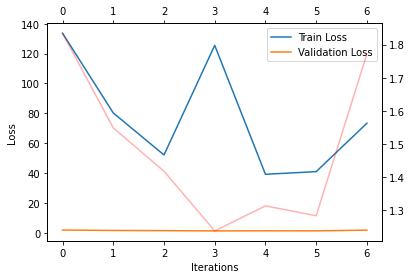

In [11]:
import matplotlib.pyplot as plt

# Plot dell'andamento della perdita
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Crea un secondo asse y per la perdita di addestramento
plt.twinx()
plt.twiny()
plt.plot(val_loss_list, 'r', alpha=0.3)  # Usiamo il colore rosso per la perdita di addestramento
plt.ylabel('Validation Loss')

plt.show()

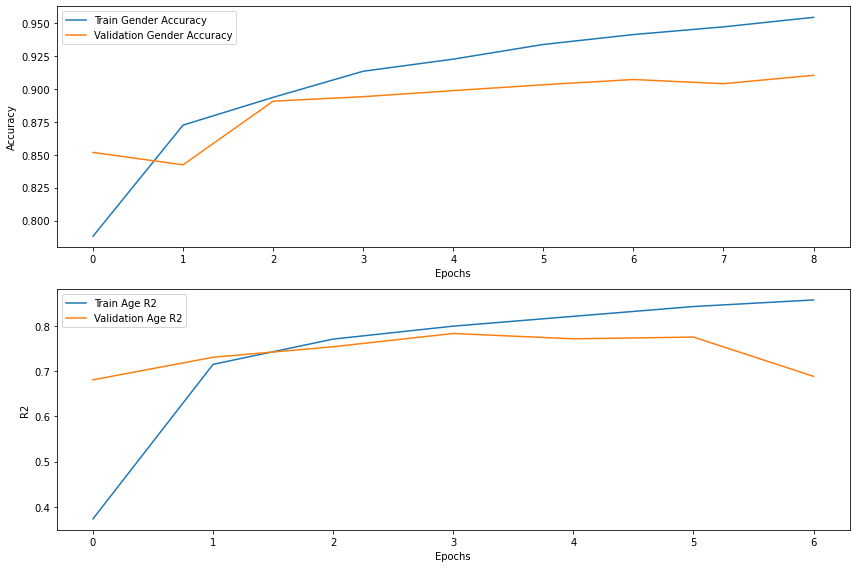

In [12]:
# Plot dell'andamento dell'accuratezza
plt.figure(figsize=(12, 8))

# Plot per il genere
plt.subplot(2, 1, 1)
plt.plot(train_gender_accuracy_list, label='Train Gender Accuracy')
plt.plot(val_gender_accuracy_list, label='Validation Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot per l'età
plt.subplot(2, 1, 2)
plt.plot(train_age_r2_list, label='Train Age R2')
plt.plot(val_age_r2_list, label='Validation Age R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)
sample_images, _, _ = next(iter(validation_dataloader))

# Generate heatmaps
heatmaps = model.cpu().generate_heatmaps(sample_images)

# Plot the heatmaps
fig, axs = plt.subplots(1, len(sample_images) + 1, figsize=(15, 5))

print(f'axs length: {axs}')

# Plot the original images from the batch
for i, sample_image in enumerate(sample_images):
    axs[i].imshow(sample_image.permute(1, 2, 0).numpy())
    axs[i].set_title('Original Images')
    axs[i].axis('off')

# Plot the heatmaps
for i, heatmap in enumerate(heatmaps):
    axs[i + 1].imshow(heatmap.squeeze().numpy(), cmap='viridis')
    axs[i + 1].set_title(f'Conv Layer {i + 1} Activation')
    axs[i + 1].axis('off')

plt.show()

NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

feature_maps = {}

# Function to visualize feature maps for a given layer
def visualize_feature_maps(model, layer_index, input_data):
    # Set the model to evaluation mode
    model.cpu()
    model.eval()

    # Register the forward hook to get the output of the specified layer
    def hook(module, input, output):
        feature_maps[layer_index] = output.detach().cpu().numpy()

    # Get the specified convolutional layer
    layer = list(model.modules())[layer_index]

    # Register the hook
    hook_handle = layer.register_forward_hook(hook)

    # Forward pass to get the feature maps
    with torch.no_grad():
        model(input_data)

    # Remove the hook
    hook_handle.remove()

    # Visualize the feature maps
    feature_maps_data = feature_maps[layer_index]
    num_feature_maps = min(5, feature_maps_data.shape[1])  # Display only the first 3 feature maps

    # Plot each feature map
    plt.figure(figsize=(10, 3))  # Adjust the figure size
    for i in range(num_feature_maps):
        plt.subplot(1, num_feature_maps, i + 1)
        plt.imshow(feature_maps_data[0, i, :, :], cmap='viridis', aspect='auto')  # Set aspect ratio to 'auto'
        plt.title(f'Feature Map {i + 1}')
        plt.axis('off')

    plt.show()

# Assuming val_dataset and model are defined elsewhere
# Choose the first 5 images from the validation set
subset_indices = list(range(16))
subset = Subset(val_dataset, subset_indices)

visualize_loader = torch.utils.data.DataLoader(subset, batch_size=5, shuffle=False)

# Iterate over the validation loader
for inputs, _, _ in visualize_loader:
    
    # Visualize feature maps for each convolutional layer
    for layer_index in [idx for idx, layer in enumerate(model.modules()) if isinstance(layer, nn.Conv2d)]:
        visualize_feature_maps(model, layer_index, inputs)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.cuda()
# Valuta il modello sul set di val
model.eval()
with torch.no_grad():
    for i, (inputs, gender_labels, age_labels) in enumerate(val_loader):
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        gender_output, age_output = model(inputs)

        # Converte le predizioni in età e genere previsti
        predicted_age = age_output.cpu().numpy()
        predicted_gender = torch.argmax(gender_output, dim=1).cpu().numpy()

        # Età e genere reali
        real_age = age_labels.cpu().numpy()
        real_gender = gender_labels.cpu().numpy()

        # Stampa alcuni esempi
        #if i % 5 == 0:
            #for j in range(len(inputs)):
                # Visualizza l'immagine
                #img = np.transpose(inputs[j].cpu().numpy(), (1, 2, 0))
                #plt.imshow(img)
                #plt.title(f"Sample {i * len(inputs) + j + 1}")
                #plt.axis('off')
                #plt.show()

                # Stampa età e genere reali e predetti
                #print(f"Real Age: {real_age[j]}, Predicted Age: {predicted_age[j][0]:.2f}")
                #print(f"Real Gender: {'Male' if real_gender[j] == 0 else 'Female'}, Predicted Gender: {'Male' if predicted_gender[j] == 0 else 'Female'}")
                #print("\n")


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

# Assuming you have a separate test_loader for the test set
# Evaluate the model on the test set
age_model.eval()
gender_model.eval()
with torch.no_grad():
    correct_gender_test = 0
    total_test = 0
    test_age_r2 = 0
    
    test_loss_gender = 0.0
    test_loss_age = 0.0
    total_test_samples = 0

    all_predicted_genders = []
    all_true_genders = []

    all_true_ages = []
    all_predicted_ages = []

    for idx, (inputs, gender_labels, age_labels) in enumerate(test_loader):
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        gender_output = gender_model(inputs)
        age_output = age_model(inputs)

        # Sposta l'output alla stessa device di gender_labels
        gender_output = gender_output.to(gender_labels.device)
        age_output = age_output.to(age_labels.device)
        
        test_loss_gender += criterion_gender(gender_output, gender_labels).item()
        test_loss_age += criterion_age(age_output, age_labels).item()
        total_test_samples += len(inputs)

        # Calcola l'accuratezza per il genere
        _, predicted_gender = torch.max(gender_output, 1)
        correct_gender_test += (predicted_gender == gender_labels).sum().item()
        total_test += gender_labels.size(0)

        all_predicted_genders.extend(predicted_gender.cpu().numpy())
        all_true_genders.extend(gender_labels.cpu().numpy())

        # Calcola l'R2 score per l'età
        predicted_age = age_output.detach().cpu().numpy()
        test_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)

        all_true_ages.extend(age_labels.cpu().numpy())
        all_predicted_ages.extend(predicted_age)

    test_gender_accuracy = correct_gender_test / total_test
    test_age_r2 /= len(test_loader)

    avg_test_loss_gender = test_loss_gender / total_test_samples
    avg_test_loss_age = test_loss_age / total_test_samples
    total_test_loss = avg_test_loss_gender + avg_test_loss_age

    print(f'Test Loss: {total_test_loss:.4f}')
    
    print(f'Test Gender Accuracy: {test_gender_accuracy:.4f}, '
          f'Test Age R2 Score: {test_age_r2:.4f}')

    # Plot the heatmap for the confusion matrix
    confusion_matrix = pd.crosstab(np.array(all_true_genders), np.array(all_predicted_genders), rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Gender Classification')
    plt.show()

In [ ]:
# Plot the predicted age vs. ground truth age
plt.figure(figsize=(10, 6))
plt.plot(all_true_ages[0:50], label='Ground Truth Age', color='blue', marker='o')
plt.plot(all_predicted_ages[0:50], label='Predicted Age', color='red', marker='x')
plt.xlabel('Image Index')
plt.ylabel('Age')
plt.title('Ground Truth Age vs. Predicted Age')
plt.legend()
plt.show()